
 # Dispatch
 ## What is Dispatch?
 Dispatch is a discrete-event simulation (DES) model for simulating EV bus
 fleets. It leverages the power and easy availability of
 [GTFS](https://developers.google.com/transit/gtfs) data to evalutate how
 suitable it may be to electrify any given bus route found within an agency's
 feed. In addition to the simulator, it also includes tooling to aquire,
 validate, and process the GTFS feeds and other secondary data required to run
 a simulation.

 The remainder of this document serves as a hands on, in depth tutorial. We'll
 use Dispatch to evaluate bus routes for several transit agencies around the
 United States, under a variety of potential scenarios. Along the way, we'll
 detail the methods and approaches used throughout Dispatch.

 *Note: this notebook assumes a unix-like environment and that you have
 succesfully completed the instructions for installation and compliation of
 Dispatch found in the [README.md](https://github.com/nickolasclarke/dispatch)*


 ## How does Dispatch work?
 ### High Level Overview of simulation and codebase
 Using GTFS feed and secondary inputs provided, Dispatch extracts the bus
 routes and schedule for the busiest day of the year, and breaks up the
 schedule into blocks of trips that would need to be completed by a single bus.
 For example: A bus is scheduled to drive "Route F", starting from UC Berkeley
 campus, destined for downtown San Francisco. It departs at 09:00 and arrives
 at 10:00. This is a single trip. The starting and ending stops at UC campus
 and downtown SF are the trips origin and destination termini, respectively.
 This same bus is scheduled to drive the return route and back 10 times
 throughout the day, finishing its last trip at 21:00. All of these trips
 together comprise a block of trips. Using these blocks of trips, Dispatch runs
 a discrete event simulation of each block. It generates enough buses to serve
 all of the blocks, and assigns each bus a block. The block simulation then
 follows these steps:

 1. When a bus begins its assigned block of trips, its energy reserves are
    noted.
 2. Before any trip starts, a bus evaluates if it has enough energy to serve
    the full trip to its final destination.
 3. If it does have enough energy it completes the trip, subtracting the energy
    required to serve the trip from its energy reserves.
   - If a charger is present at the terminus where it completes its trip, the
     bus will opportunistically charge until it has to depart for its next
     assigned trip.
 4. It repeats this process until one of the following:
   - If it does not have enough energy, the bus returns to the nearest depot,
     and another fully charged bus replaces it.
   - If it completes its block, it returns to the nearest depot and charges.


 The results of completing each block are noted and then passed to Dispatch's
 optimizer, which uses the results to find the least cost, optimized
 configuration of bus starting depot and charger placement for the given
 scenario parameters. The final output are three part:
 1. The number of buses, chargers, and the associated fiscal cost for the
    optimized configuration
 2. The block results of the optimized configuration, detailing where and when
    bus swaps occured.
 3. The distrubution of buses across the depots in the optimized configuration.

 Dispatch's codebase consists of two major parts: data pipeline, and
 simulation. The main components you will likely use as part of Dispatch are
 seen below.

 - Data pipeline
   - `build/bin/pull_gtfs.py`
   - `build/bin/osm_splitter.py`
 - Simulation
   - `build/bin/scenarios.py`
     - `build/bin/sim.py`


 ### Data pipeline
 As noted in the introduction, the data pipeline tools allow the user to
 aquire, validate, and process the GTFS feeds and some of other secondary data
 required to run a simulation. While Dispatch tries to do as much of the heavy
 lifting for you, the tooling is not complete and some data will have to be
 aquired seperately.

 To run a simulation, you need aquire and process the following outside data:
  - A valid GTFS feed
    - Full tooling provided by Dispatch
  - A [OSM PBF](https://wiki.openstreetmap.org/wiki/PBF_Format) file of the
    roadways in the area covered by the GTFS feed
    - Partial tooling provided by Dispatch
  - A CSV of bus depot locations `TODO document this in readme`
    - Must be manually created

 The primary data used by Dispatch is a valid GTFS feed that contains bus
 routes as part of the feed. Anyone can create a GTFS feed, and many agencies
 and organziations publish their feeds on their own websites or developer
 portals. Any valid feed, no matter where it has been aquired, can be used by
 Dispatch, although it would have be processed manually using
 `build/bin/parse_gtfs.py`. However,
 [OpenMobilityData](https://transitfeeds.com/) acts as the most complete open
 registry of GTFS feeds from around the world, with free and easy API access to
 nearly 1000 feeds, many of which are updated regularly by the feed authors.
 Since Dispatch aims to provide easy simulation of all GTFS feeds that contain
 bus routes, Dispatch uses OpenMobilityData's API to download and validate all
 available feeds, while storing information about our local cache of feeds in a
 simple [`shelve` database](https://docs.python.org/3/library/shelve.html).


 #### Aquire GTFS feeds
 This is where we'll begin. We use `build/bin/pull_gtfs.py`, which is written
 as a CLI tool. We'll start by downloading all the feeds, placing them in the
 `data/` subfolder and writing the results to the `data/feeds.db` shelve file.

 `./../build/bin/pull_gtfs.py acquire_remote ../data/feeds.db`

 *Note: all shell commands are wrapped in `\`\ code blocks. You can run them
 outside of this notebook, or simply create a normal code cell and use the
 shell command prefixed with a `!` to instruct jupyter to run the command.* %%
 [markdown]
 ### Validate GTFS feeds and generate input files
 Once the feeds have been downloaded, we'll need to validate if the feeds can
 be used by Dispatch. There are many reasons why a feed may not be valid for
 our purposes. First and foremost, we confirm that the feed can be read. Next,
 a feed must contain [bus
 routes](https://developers.google.com/transit/gtfs/reference/extended-route-types).
 A feed must also include the optional [`block_id`
 parameter](https://developers.google.com/transit/gtfs/reference#routestxt) as
 part of its `trips.txt`. Dispatch relies on `block_id` to determine what block
 of trips a bus should be assigned to in a simulation. Future work could permit
 us to synthetically create these `block_id`s for feeds that do not them.

 To validate all the feeds, we call:

 `./../build/bin/pull_gtfs.py validate ../data/feeds.db`


 If a feed is determined to be valid for use by Dispatch, this
 operation automatically parses the feed into several geopandas dataframes,
 which are then written out as CSVs for portability between python and C++.
 These files, `*_stops.csv`, `*_stop_times.csv`, and `*_trips.csv`, are written
 to the `data/` subfolder, prefixed with `parsed_<GTFS_feed_name>_`. Any of
 these files can be loaded by geopandas as a geodataframe for troubleshooting.


 ### Find OSM extents
 Next we find the spatial extents of the feed. This is used later to build a
 OSM.PBF file of the road network within these bounds. While the bus route
 shapes are included as part of GTFS and used by Dispatch, the full road
 network is also required to find the least-distance route back to the nearest
 bus depot when a bus has either completed its block of trips, is too low on
 energy to complete its block and needs to be replaced by another fully charged
 bus.

 To find the extents of all the valid feeds, we call:
`./../build/bin/pull_gtfs.py extents ../data/feeds.db > ../data/extents`

 ### Split up planet-wide OSM data
 With the extents we can generate the OSM roadway data for each feed. However,
 this step requires you have aquired and processed a planet.osm file, as
 outlined in the
 [README.md](https://github.com/nickolasclarke/dispatch#global-road-network).
 Once you have completed these steps, you can split your planet-wide OSM file
 into smaller individual files for each valid feed.

 To split and generate feed-specific OSM roadway data, we call:

`./../build/bin/osm_splitter ../data/planet-highways.osm.pbf ../data/extents 0.0288`

 However, all the steps in this section are very computationally
 expensive. With our 32 core, 192 GB RAM, SSD-backed device, completing these
 steps takes more than 24 hours. While intensive, once this process is
 complete, you should be able to use the resulting output for each GTFS feed
 until you have reason to believe that the road network has changed drastically
 enough to warrant regenerating the split files. Currently this would require
 starting with an updated planet-wide OSM file and reprocessing from that
 point.

 As long as you have confidence in the accuracy of the files, you can share
 them between installations of Dispatch. As such, we'll forgo these steps in
 the tutorial. We've included the split osm.pbf files for the city we'll be
 simluating in the `examples/sample_data` folder.


 #### Generate bus depot data
 In addition to the GTFS feed and OSM road network data we've generated,
 Dispatch also requires the locations of the bus depots within a feed's
 extents. Unfortunately depot locations are not currently provided as part of
 the GTFS specification. While hueristics could be developed to generated
 presumed depot locations, Dispatch does not have this funcationality as of
 yet. A depot file is a CSV that consists of the following fields where each
 row is a discrete depot located within the extents:

 ```
 lat : float
         latitude of depot, i.e. 40.764054
 lng : float
   longitude of depot, i.e. -111.910789
 name : str
   name of the depot, i.e. "UTA Central Bus Depot"
 max_buses : int
   bus capacity of the depot, i.e. 150
 url : str
   hyperlink to source of depot details i.e. "https://rideuta.com/"
 ```

 These can be actual depots as they exist today, theorteical depots, or both in
 any combination. There is no limit to the number of depots you can have. For
 the cities we'll simulate, these depot files were generated by hand, using
 data from the transit agencies and beyond to determine the location of depots
 within the cities. Dispatch includes some depot files for feeds we or other
 users have evalutated and submitted. They are provided in the `data/depots/`
 folder. As you create or update existing depot files, feel free to submit a PR
 to have it included with Dispatch.

 Note, a depot is often distinct from a major bus terminus. While some transit
 agencies may colocate bus termini, which would appear in the feed details,
 with a bus depot, this is often not the case. This means that where buses
 begin and finish their trip block may not be at a depot. These buses
 [deadhead](https://en.wikipedia.org/wiki/Dead_mileage) to and from the routes
 they serve.


 ### Simulation
 We now have a complete set of data inputs, we can begin to simulate a feed.
 Before we run our first simulation, lets dig into some more of the details of
 how a single run of a Dispatch simulation works. The Dispatch C++ simulation
 module contains the logic for simulation as well as optimization. Any single
 run of `dispatch.run_model()` follows the four step logic spelled out earlier]
 (*see How does Dispatch work?*) for all the blocks of trips. Any one run will
 randomly place a number of chargers at termini, as well as randomly assign
 buses to depots, up to the depot capacity limit, and run a simuluation,
 returning unoptimized costs and figures. The costs values returned are assumed
 to be fiscal costs for the following:

 - Base bus cost: floor price of a bus without any battery capacity
 - Battery price per kWh
 - Cost of all chargers at a depot
 - Cost of an individual charger at a terminus


 *Note: Dispatch currently requires homogenous fleets, so all buses and
 chargers will be identitical*

 Estimating these costs is difficult. The cost of hardware, installation,
 infrastructure upgrades vary wildly between territories, and are changing
 rapidly. The current defaults are best guesses from the literature, industry
 figures, and expert interviews, represented as absolute costs. The opinionated
 `scenarios.py` tool introduced later, provides a method for annualizing these
 costs, but you should consider what cost values are most accurate for the
 feeds you would like to evalutate and override these defaults accordingly.
 You'll note we do not currently include energy costs, which proved too
 difficult to generalize in our initial attempts, as well as other costs like
 operations and maintenance, training, etc.

 In order to find the optimal configuration we use `dispatch.optimize_model()`.
 Given the nature of our problem, we do not know of a way to represent it in a
 closed-form solution using solvers available to us. Thus
 `dispatch.optimize_model()` is implemented as a black-box optimizer that uses
 a genetic algorithm.

 Using a genetic algorithm, Dispatch runs many different instances of the model
 in a generation, each with a random configuration. The top instances with the
 lowest costs are saved from each generation, and are used to spawn new model
 instancse for the next generation, with a progressively decreasing mutation
 rate for each generation. After an arbitrary number of generations as
 specified in the model paramters, the least cost instance in the final
 generation is given as the final, optimized result.

 However, it t is unlikely you'll need to use the `Dispatch` C++ module
 directly. Instead `build/bin/sim.py` acts as a wrapper around the Dispatch
 module and the main interface one would typically use.By importing and calling
 `sim` we can quickly complete a optimized run of Dispatch. For this we'll use
 data for [AC Transit](http://www.actransit.org/).

 Note: This is somewhat compute intensive, but should be excutable by a modern
 laptop in the range of 5 ~ 25 minutes.

In [1]:
# Sim is usually used as part of a script. Here we change the pwd from the
# `examples/` dir  we've been working in previously, so we can import it
# properly.
 
%cd ../build/bin


/mnt/c/Users/nicko/repos/dispatch/build/bin


In [2]:

from sim import simulate as sim

#the path and prefix of the parsed csv files of the target feed
parsed_gtfs_prefix = '../../examples/actransit/parsed_actransit121'
#the path to the osm.pbf file of the road network of the target feed
osm_data = '../../examples/actransit/osm_actransit121.osm.pbf'
#the path to the depot csv file for the target feed
depots_filename = '../../examples/actransit/depots_actransit.csv'

results = sim(parsed_gtfs_prefix,osm_data,depots_filename)


Parsing OSM data into router...
Scenario Parameters: <dispatch.Parameters battery_cap_kwh=200, kwh_per_km=1.2, bus_cost=500000, battery_cost_per_kwh=100, depot_charger_cost=50000, depot_charger_rate=125, nondepot_charger_cost=600000, nondepot_charger_rate=500, chargers_per_depot=1, generations=[vec], mutation_rate=[vec], keep_top=[vec], spawn_size=[vec], restarts=1, seed=0>
Getting nearest depots...
Testing to see if all depots are near nodes...
Creating model...
Cost with no chargers...
No Chargers Cost $364,150,000.00
No Chargers Total buses: 700
No Chargers Total chargers: 0
Cost with all chargers...
No Chargers Cost $391,030,000.00
No Chargers Total buses: 244
No Chargers Total chargers: 440
Optimizing with chargers...
Optimized Cost $250,910,000.00
Optimized buses: 293
Optimized chargers: 164



 `results` gives use a dict of the number of buses, chargers, and
 costs for the optimized configuration, as well as the same if the all termini
 or no termini had chargers, respectively. The dict also has a dataframe of the
 results of each running each `block_id` for the optimized configuration. This
 dataframe details where and when bus swaps occured. Finally, we also have the
 count of buses at each depot for the optimized configation.

 Let's take a look at some of these results:

In [3]:
bus_count = results['opti_buses']
charger_count = results['opti_chargers']
optimized_cost = results['opti_cost']

print(f'optimized Bus Count:{bus_count}\n \
optimized Charger Count: {charger_count}\n \
Optimized Cost: $ {optimized_cost}')


optimized Bus Count:293
 optimized Charger Count: 164
 Optimized Cost: $ 250910000.0



 Feel free to explore the `results` dict further. We'll get into
 more sophisticated results analysis later on.

 Note: `sim` supports an optional input `parameters`, which defaults to `None`.
 It accepts a dict of simulation and optimizer parameters that selectively
 override the [default
 values](https://github.com/nickolasclarke/dispatch/blob/eeb12e70780a6d996a956a746aa79522aa6ae752/src/sim.py#L75)
 used by `sim`. These include things such as battery capacity, charger power,
 powertrain efficiency, etc. Just as with the costs, we've attempted to include
 sensible defaults. However, you should evaluate if the defaults make sense for
 the feeds you want to simulate.


 #### Evaluating multiple scenarios
 If you are only interested getting results for a single scenario, using `sim`
 directly, as done above may be sufficent for your needs. Simply pass what
 values you'd like to override via `parameters`. However, given how rapidly EV
 technologies are advancing, you may want to evaluate multiple scenarios based
 on different technical and fiscal considerations. Dispatch includes an
 opinionated tool, `build/bin/scenarios.py` that acts as a wrapper on `sim` to
 run multiple scenarios against a single feed. Given a range of battery
 capacities and non-depot charger powers, `scenarios` generates a list the
 possible scenarios and their associated annualized costs, and then evaluates
 them with `sim`. It writes the outputs to the output directory provided.

 Let's run a few scenarios, using AC Transit data again. Since `scenarios` is a
 wrapper on `sim` it takes the same required inputs. `scenarios` also requires
 an output directory where resulting CSVs can be written, and details
 about the range of scenarios you'd like to run.

In [4]:
from scenarios import main as scenarios

#the path where the output files for each scenario should be written
output_path = '../../examples/out/actransit121/'
#inputs to an np.arange() of battery capacities and non-depot charger power
battery_cap_kwh = [220,661,200]
nondepot_charger_rate = [100,501,200]

#run each scenario, in series. We reuse the input variables from running sim.py
#directly. 
scenarios(parsed_gtfs_prefix,osm_data,depots_filename,output_path,
  battery_cap_kwh, nondepot_charger_rate)


Parsing OSM data into router...
Scenario Parameters: <dispatch.Parameters battery_cap_kwh=220, kwh_per_km=1.2, bus_cost=57172.5, battery_cost_per_kwh=81.6434, depot_charger_cost=50000, depot_charger_rate=125, nondepot_charger_cost=45740.3, nondepot_charger_rate=100, chargers_per_depot=1, generations=[vec], mutation_rate=[vec], keep_top=[vec], spawn_size=[vec], restarts=1, seed=0>
Getting nearest depots...
Testing to see if all depots are near nodes...
Creating model...
Cost with no chargers...
No Chargers Cost $51,466,536.32
No Chargers Total buses: 683
No Chargers Total chargers: 0
Cost with all chargers...
No Chargers Cost $65,280,993.99
No Chargers Total buses: 599
No Chargers Total chargers: 440
Optimizing with chargers...
Optimized Cost $50,823,472.36
Optimized buses: 630
Optimized chargers: 73
Parsing OSM data into router...
Scenario Parameters: <dispatch.Parameters battery_cap_kwh=220, kwh_per_km=1.2, bus_cost=57172.5, battery_cost_per_kwh=81.6434, depot_charger_cost=50000, depo

 We can see the output results here:

In [5]:
! ls ../../examples/out/actransit121


220kwh_100_kw_depot_counts.csv	420kwh_500_kw_depot_counts.csv
220kwh_100_kw_trips.csv		420kwh_500_kw_trips.csv
220kwh_300_kw_depot_counts.csv	620kwh_100_kw_depot_counts.csv
220kwh_300_kw_trips.csv		620kwh_100_kw_trips.csv
220kwh_500_kw_depot_counts.csv	620kwh_300_kw_depot_counts.csv
220kwh_500_kw_trips.csv		620kwh_300_kw_trips.csv
420kwh_100_kw_depot_counts.csv	620kwh_500_kw_depot_counts.csv
420kwh_100_kw_trips.csv		620kwh_500_kw_trips.csv
420kwh_300_kw_depot_counts.csv	scenarios_results.csv
420kwh_300_kw_trips.csv


# How do I interpet the results?
 Answering this depends on your motivations for using Dispatch. Who is your
 audience? What questions do you hope to answer with Dispatch? Dispatch
 provides an estimated least-cost for a fully electrified system, but fully
 capturing the true costs can be difficult. Still, these estimated costs,
 especially when compared across many different scenarios, can provide insights
 into when and how a transition to an EV fleet could happen.

 In addition, while costs and counts for a given scenario are representative of
 the feed as a whole, the results given in `<scenario_prefix>_trips.csv` can
 provide more granular insights into what blocks, routes, and termini could the
 best canidates for electrification, or not. Lets dig in a bit further to both
 the summary results as well as the more granular data to better understand
 what Dispatch can tell us. In addition to the data we generated earlier for AC
 Transit, we'll also look at data previously generated for Salt Lake City, Las
 Vegas, and Minneapolis.

 First lets begin by importing a few of the tools and data we'll need for some
 of this analysis and define some helper functions that will be used for
 various plots of the results.

In [6]:
#change pwd back to `examples/` dir for the remainder
%cd ../../examples

import numpy as np
import pandas as pd
import geopandas as gpd
import partridge as ptg
import contextily as ctx

import matplotlib.pyplot as plt

from matplotlib import ticker
from sklearn.preprocessing import minmax_scale


/mnt/c/Users/nicko/repos/dispatch/examples


In [7]:
# load results
scen_labels = ['220kWh/100kW','220kWh/300kW','220kWh/500kW',
               '420kWh/100kW','420kWh/300kW','420kWh/500kW',
               '620kWh/100kW','620kWh/300kW','620kWh/500kW',]

all_res = {
    'Utah Transit Authority (UT)': pd.read_csv('uta/scenarios_results.csv'),
    'Metro Transit (MN)': pd.read_csv('mn/scenarios_results.csv'),
    'RTC Southern Nevada (NV)': pd.read_csv('vegas/scenarios_results.csv'),
    'AC Transit (CA)': pd.read_csv('actransit/scenarios_results.csv')
    }
res_normed = pd.DataFrame(scen_labels, columns=['scenario'])

#add scenarios labels and normalized values
for key in all_res.keys():
    all_res[key]['scenario'] = scen_labels
    all_res[key]['optcost_norm'] = minmax_scale(all_res[key]['optimized_cost'])
    res_normed[['battery_cap_kwh','nondepot_charger_rate',key]] =  all_res[key][
        ['battery_cap_kwh','nondepot_charger_rate','optcost_norm']]

#a dataframe of the scenario least-cost ranking, using normalized data from all
#cities
res_normed['mean'] = res_normed[all_res.keys()].mean(axis=1)


In [8]:
# Define helper functions
def gen_subplots(results, **figkw):
    """Helper function to set up figure"""
    fig, axes = plt.subplots(2,2,sharey=True, sharex=True,)
    ax_map = dict(zip(results.keys(),axes.flat))
    return (fig, axes, ax_map)

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel,rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    # ax.tick_params(top=True, bottom=False,
    #                labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",)
             #rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) < threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts



 We'll start by simply plot the counts of buses and non-depot
 chargers for each scenario. We'll make a subplot for each transit agency we
 have data for.

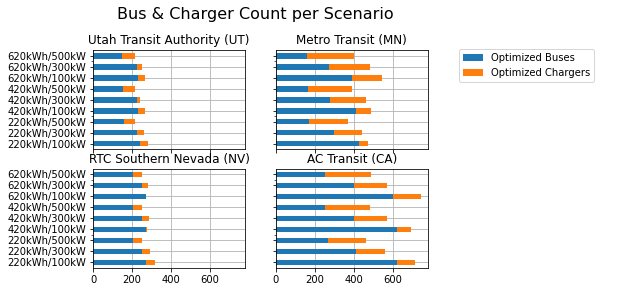

In [9]:
def plot_counts(results):
    """TODO
    One plot per city, plot all scenarios along X, 5 bars per step. 
    Optimized Bus + Chargers, AC B+C, NC Bus.
    """
    fig, axes, ax_map = gen_subplots(results)
    for i,key in enumerate(all_res):
        ax = ax_map[key]
        df = results[key][['optimized_buses','optimized_chargers','scenario']]
        df.plot.barh(x='scenario',stacked=True, ax=ax, legend=False, zorder=2)
        ax.grid(zorder=0)
        ax.set_title(key)
        ax.set_ylabel('')
    handles, _ = ax.get_legend_handles_labels()
    fig.legend(handles,['Optimized Buses','Optimized Chargers'],
               bbox_to_anchor=(1.05,0.86), loc='upper left')
    fig.suptitle('Bus & Charger Count per Scenario',fontsize=16, y=1.03)

plot_counts(all_res)


 For Metro and AC Transit, which are both much more sophisticated
 transit agencies we can see both higher overall needs, as well as a more even
 balance of buses to chargers in their scenarios. However geography, route
 design, and trip block design are also potential factors impacting these
 results.

 Meanwhile both SLC and Las Vegas have a much stronger prefernce for buses over
 chargers. Las Vegas even appears to have no non-depot chargers required in one
 scenario.

 Next, lets take a look at the costs for each scenario.

/home/nclarke/.pyenv/versions/3.7.7/envs/dispatch/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


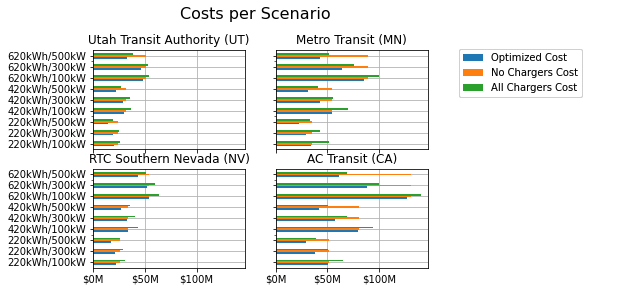

In [10]:
def plot_costs(results):
    """
    TODO One plot per city, plot all scenarios along X, 3 bars per step:
    Optimized Costs
    AC costs
    NC costs
    """
    fig, axes, ax_map = gen_subplots(results)
    # add common x, y. X works, Y is set too far inside
    for i,key in enumerate(all_res):
        ax = ax_map[key]
        df = results[key][['optimized_cost','nc_cost','ac_cost','scenario']]
        df_round = df[['optimized_cost','nc_cost','ac_cost']]
        df[['optimized_cost','nc_cost','ac_cost']] = (df_round/1e6).round(2)
        df.plot.barh(x='scenario', ax=ax, legend=False, zorder=2)
        ax.grid(zorder=0)
        formatter = ticker.FormatStrFormatter('$%.0fM')
        ax.xaxis.set_major_formatter(formatter)
        ax.set_title(key)
        ax.set_ylabel('')
        handles, _ = ax.get_legend_handles_labels()
        fig.legend(handles,['Optimized Cost','No Chargers Cost','All Chargers Cost'],
            bbox_to_anchor=(1.05,0.86), loc='upper left')
    fig.suptitle('Costs per Scenario', fontsize=16, y=1.03)

plot_costs(all_res)


 Under our scenario parameters, there is a clear preference for higher charger
 power over additional battery capacity. However, there may be situations where
 the charger densities required by Dispatch are not feasible in practice. We
 also provide optimized prices for the extremes, with least-costs for all
 termini having a charger, as well as no chargers. In the latter scenario, all
 charging happens at the depots when the buses are out of service.


Viewing these costs as a heatmap can be helpful to identify trends across
 scenario configurations. Here we'll create a heatmap of costs, with battery
 capacity and charger power along the axes. We'll include the cost for the
 scenario printed inside each cell.

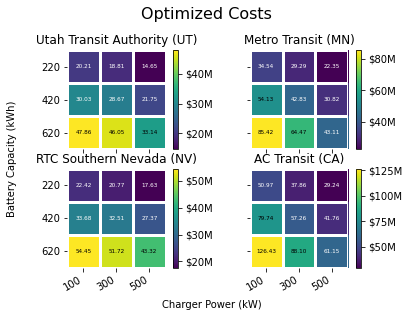

In [11]:
def plot_heatmap(results, columns):
    """TODO
    Optimized cost as heatmap. One plot per city, each cell a scenario.
    """
    fig, axes, ax_map = gen_subplots(results)
    
    # add common x, y. X works, Y is set too far inside
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    for i,key in enumerate(results):
        ax = ax_map[key]
        df = results[key][columns]
        # arrange results along battery and charger power axes using a pivot table
        piv = pd.pivot_table(df,index='battery_cap_kwh',columns='nondepot_charger_rate')
        #format float for millions USD
        piv = (piv/1e6).round(2)

        xlabels = [int(power) for _,power in piv.columns] #as ints for simplicity
        ylabels = piv.index.astype(int)
        im, cbar = heatmap(piv,xlabels,ylabels,cbar_kw={'format':'$%.0fM'},ax=ax)
        annotate_heatmap(im,size='xx-small')
        ax.set_xticklabels(xlabels)
        ax.set_yticklabels(ylabels)
        ax.set_title(key)

    plt.xlabel('Charger Power (kW)', labelpad=15)
    plt.ylabel('Battery Capacity (kWh)')
    fig.suptitle('Optimized Costs', fontsize=16, y=1.03)

plot_heatmap(all_res,['optimized_cost',
                      'battery_cap_kwh',
                      'nondepot_charger_rate'
                     ])

 Here we can even more clearly see the trend towards high charger capacity and
 low battery sizes. Moreover, we can see the large range of costs. The
 difference between the lowest and highest cost scenario being an order of
 magnitude for AC Transit.

 But what if we want to understand the likelihood that any given scenario
 will be the least-cost across many different cities. This could be useful for
 understanding trends across all our evaluated feeds. First we'll want to do a
 min/max normalization of the costs, and then we can plot a heatmap just as
 before.

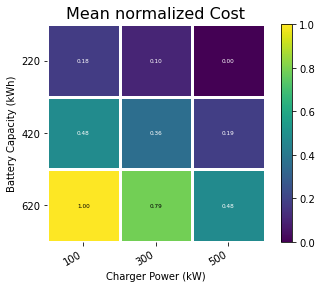

In [12]:
def plot_hm_norm(data):
    fig, ax = plt.subplots()
    df = data[['mean','battery_cap_kwh','nondepot_charger_rate']]
    piv = pd.pivot_table(df,index='battery_cap_kwh',columns='nondepot_charger_rate')
    xlabels = [int(power) for _,power in piv.columns] #as ints for simplicity
    ylabels = piv.index.astype(int)
    im, cbar = heatmap(piv, xlabels, ylabels,ax=ax)
    annotate_heatmap(im,size='xx-small')
    ax.set_xlabel('Charger Power (kW)')
    ax.set_ylabel('Battery Capacity (kWh)')
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)
    ax.set_title('Mean normalized Cost',fontsize=16)

plot_hm_norm(res_normed)


 Finally, lets do a bit of basic spatial analysis. For this we'll
 use the least cost scenario for each city. We'll plot all the routes
 evaluated. We'll also plot the routes that experienced a bus swap.

/home/nclarke/.pyenv/versions/3.7.7/envs/dispatch/lib/python3.7/site-packages/ipykernel_launcher.py:60: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.


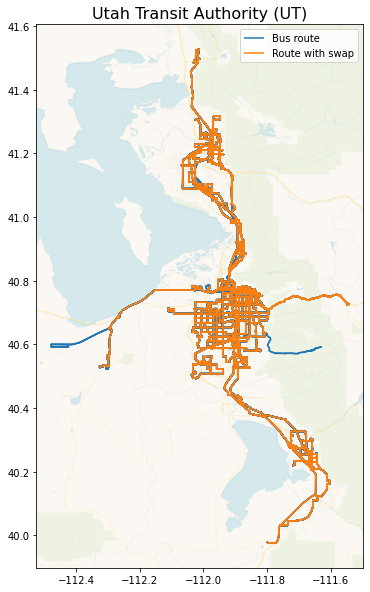

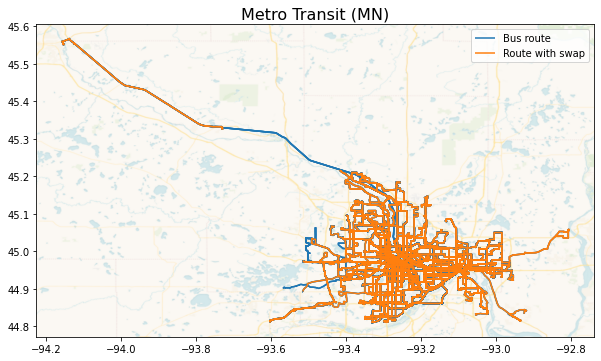

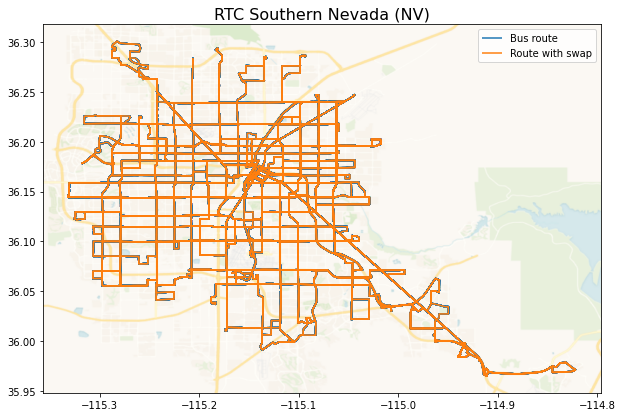

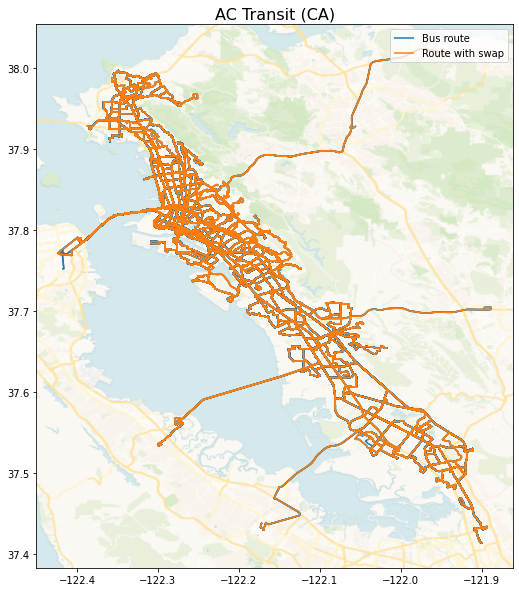

[None, None, None, None]

In [13]:
# first set up the paths to the various data we need from `examples/`
paths = {'Utah Transit Authority (UT)':{'gtfs':'uta/gtfs_utahtransportationauthority59.zip',
                                        'prefix':'uta/parsed_utahtransportationauthority59',
                                        'depot':'uta/depots_utahtransportationauthority59.csv',
                                        'scen':'uta/220kwh_500_kw_trips.csv'
                                       },
                  'Metro Transit (MN)':{'gtfs':'mn/gtfs_metrotransit179.zip',
                                        'prefix':'mn/parsed_metrotransit179',
                                        'depot':'mn/depots_minneapolis.csv',
                                        'scen':'mn/220kwh_500_kw_trips.csv'
                                       },
             'RTC Southern Nevada (NV)':{'gtfs':'vegas/gtfs_rtcsouthernnevada47.zip',
                                        'prefix':'vegas/parsed_rtcsouthernnevada47',
                                        'depot':'vegas/depots_rtcsnv.csv',
                                        'scen':'vegas/220kwh_500_kw_trips.csv'
                                       },
                    'AC Transit (CA)': {'gtfs':'actransit/gtfs_actransit121.zip',
                                        'prefix':'actransit/parsed_actransit121',
                                        'depot':'actransit/depots_actransit.csv',
                                        'scen':'actransit/220kwh_500_kw_trips.csv'
                                       }
        }

def plot_map(data,fig_title=None):
    """
    One plot per city. Plot all routes and termini. Plot which termini and routes
    experience a swap. Extra credit, cmap the swap counts per termini and route. 
    Since these will be variable dimensions, plot one at a time. 
    """
    gtfs_path = data['gtfs']
    prefix_path = data['prefix']
    depot_path = data['depot']
    scen_path = data['scen']
    # load the raw GTFS feed, as well as our parsed gtfs inputs
    date, service_ids = ptg.read_busiest_date(gtfs_path)
    feed = ptg.load_geo_feed(gtfs_path)
    trips = gpd.read_file(f'{prefix_path}_trips.csv')
    stops = gpd.read_file(f'{prefix_path}_stops.csv')
    opti_trips = pd.read_csv(scen_path, index_col=0)

    #filter the raw GTFS feed for the trips we served, and extract shape geometry
    trips_filtered = feed.trips[feed.trips['trip_id'].isin(trips['trip_id'])]
    shapes = feed.shapes[feed.shapes['shape_id'].isin(trips_filtered['shape_id'])]
    trips_filtered = pd.merge(trips_filtered,shapes,left_on='shape_id',right_on='shape_id')
    trips_filtered = gpd.GeoDataFrame(trips_filtered,crs='epsg:4326')
    
    #find which block_ids experienced swap events, 
    swap_blocks = opti_trips.groupby('block_id')['bus_id'].nunique() > 1
    swap_blocks = swap_blocks[swap_blocks == True]
    swap_shapes = trips_filtered[trips_filtered['block_id'].isin(swap_blocks.index.astype(str))][['route_id','shape_id','geometry']]
    swap_shapes = swap_shapes.groupby('shape_id').first() #drop duplicate shapes_ids
    swap_shapes = gpd.GeoDataFrame(swap_shapes,crs='epsg:4326')
    
    #plot the map
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect('equal')
    tile_url = 'https://{s}.basemaps.cartocdn.com/rastertiles/voyager_nolabels/{z}/{x}/{y}{r}.png'
    trips_filtered['geometry'].plot(ax=ax,color='C0', label='Bus route')
    swap_shapes.plot(ax=ax,color='C1',label='Route with swap')
    ctx.add_basemap(ax=ax, crs='epsg:4326', url=tile_url)
    ax.set_title(fig_title, fontsize=16)
    plt.legend()
    plt.show()

#plot the maps
[plot_map(dic,key) for key,dic in paths.items()]


 Since the least-cost scenario for all these cities was 220kwh/500kw, it is not
 surprising that many routes experience swaps. However, in scenarios where such
 a configuration is not possible and higher battery capcity is required, we
 may see more routes without any swap events. These routes may be particularly
 well suited to electrification sooner rather than later.

 This is by no means an exhaustive list of ways to analyze the results from
 Dispatch. However, this should give you a good feel for what is possible. If
 you find any analysis particularly useful, please feel free to expand on our
 example tutorials here by submitting a PR to the project.